In [1]:
if(!require(plyr)) install.packages(c("plyr")) # revalue()
library(plyr)
if(!require(ROCR)) install.packages(c("ROCR")) #ROC
library(ROCR)
if(!require(e1071)) install.packages(c("e1071")) #Naive Bayes & svm
library(e1071)
if(!require(caret)) install.packages(c("caret")) #confusion matrix
library(caret)
if(!require(rpart)) install.packages(c("rpart")) #decision tree
library(rpart)
if(!require(rpart.plot)) install.packages(c("rpart.plot")) #decision tree
library(rpart.plot)
if(!require(class)) install.packages(c("class")) #knn
library(class)
if(!require(parallel)) install.packages(c("parallel")) #parallel
library(parallel)
if(!require(dplyr)) install.packages(c("dplyr")) #move column
library(dplyr)

Loading required package: plyr

Loading required package: ROCR

Loading required package: e1071

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice

Loading required package: rpart

Loading required package: rpart.plot

Loading required package: class

Loading required package: parallel

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
pdf("hw2.pdf")

In [2]:
data = data.frame(read.csv('data/BNG_labor.csv'))

# label encoding from eda.
data$cost.of.living.adjustment <- as.factor(data$cost.of.living.adjustment)
data$pension <- as.factor(data$pension)
data$education.allowance <- as.integer(as.character(revalue(data$education.allowance, c('no'=0, 'yes'=1))))
data$vacation <- as.integer(as.character(revalue(data$vacation, c('average'=1, 'below_average'=2, 'generous'=3))))
data$longterm.disability.assistance <- as.integer(as.character(revalue(data$longterm.disability.assistance, c('no'=0, 'yes'=1))))
data$contribution.to.dental.plan <- as.integer(as.character(revalue(data$contribution.to.dental.plan, c('none'=0, 'half'=1, 'full'=2))))
data$bereavement.assistance <- as.integer(as.character(revalue(data$bereavement.assistance, c('no'=0, 'yes'=1))))
data$contribution.to.health.plan <- as.integer(as.character(revalue(data$contribution.to.health.plan, c('none'=0, 'half'=1, 'full'=2))))
data$class <- as.integer(as.character(revalue(data$class, c('bad'=0, 'good'=1))))

#split data int train and test
set.seed(43)
index <-  sort(sample(nrow(data), nrow(data)*.8))
train <- data[index,]
test <-  data[-index,]
#downsample
subtrain0 <- train[train$class == 0,] #controls
row.name <- rownames(train[train$class == 1,])
set.seed(43)
resample <- sample(row.name, nrow(subtrain0), replace = F)
subtrain1 <- train[resample,]  #cases
train <- rbind(subtrain0,subtrain1)
#shuffle
set.seed(42)
rows <- sample(nrow(train))
train <- train[rows, ]

#feature engineering
numericVarNames = names(data[,sapply(train, is.numeric)])

train_numeric <- train[, names(train) %in% numericVarNames]
train_factor <- train[, !names(train) %in% numericVarNames]
test_numeric <- test[, names(test) %in% numericVarNames]
test_factor <- test[, !names(test) %in% numericVarNames]

train_dummy <- as.data.frame(model.matrix(~.-1, train_factor))
test_dummy <- as.data.frame(model.matrix(~.-1, test_factor))

train <- cbind(train_numeric, train_dummy)
test <- cbind(test_numeric, test_dummy)

# remove cost.of.living.adjustmentnone due to correlation test
drop <- c("cost.of.living.adjustmentnone") 
train <- train[,!(names(train) %in% drop)]
test <- test[,!(names(test) %in% drop)]

train$class <- as.factor(train$class)

### Algorithm 1: Logistic Regression by using GLM

In [161]:
#Base Model
start_time <- Sys.time()
log_model <- glm(class~., data=train, family=binomial(link=logit))
end_time <- Sys.time()
log_train_difference <- difftime(end_time, start_time, units='secs')
print(log_train_difference)

Time difference of 5.674098 secs


In [106]:
summary(log_model)


Call:
glm(formula = class ~ ., family = binomial(link = logit), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4073  -0.1244   0.0011   0.2645   4.3619  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -10.047065   0.129504  -77.58   <2e-16 ***
duration                         0.563124   0.007857   71.67   <2e-16 ***
wage.increase.first.year         0.883956   0.005000  176.80   <2e-16 ***
wage.increase.second.year        0.297734   0.005106   58.32   <2e-16 ***
wage.increase.third.year         0.554255   0.006277   88.30   <2e-16 ***
working.hours                   -0.234427   0.002728  -85.93   <2e-16 ***
standby.pay                      0.049388   0.001739   28.40   <2e-16 ***
shift.differential               0.069893   0.001628   42.93   <2e-16 ***
education.allowance              1.402621   0.013359  104.99   <2e-16 ***
statutory.holidays               0.433953   0.004244

### Model Evaluation
#### In model evaluation, we will first get the confuse matrix, then calculate accuracy, precision, recall, f1, AUC and draw ROC plot.

In [107]:
test.performance <- function(confusion_matrix){
    # performance on test data set.
    print("Performance on test data")
    # accuracy
    accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)

    #precision: p = TP/(TP+FP)
    #recall: r = TP/(TP+FN)
    #true positive rate(same as recall, aka sensitivity): tpr = TP/(TP+FN)
    #false positive rate: fpr = FP/(FP+TN)
    #true negative rate(1-false positive rate, aka specificity): tnr = 1-fpr
    tp = confusion_matrix[2, 2]
    fp = confusion_matrix[1, 2]
    tn = confusion_matrix[1, 1]
    fn = confusion_matrix[2, 1]
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr = 1-fpr

    # f1 score: f1 = 2*p*r/(p+r)
    f1 = 2*p*r/(p+r)

    performance <- matrix(c(accuracy, p, r, fpr, tnr, f1), ncol=1)
    colnames(performance) <- c("Value")
    rownames(performance) <- c("Accuracy","Precision","Recall(sensitivity)", "FPR", "TNR(specificity)", "F1")
    performance <- as.data.frame(performance)
    head(performance, 6)
}

In [108]:
# logistic regression model accuracy on training data.
log_train <- predict(log_model, train[, c(-15)], type =  "response")
log_train_table_mat = table(train$class, log_train > 0.5) 
log_train_accuracy <- sum(diag(log_train_table_mat)) / sum(log_train_table_mat)
print(paste("train accuracy: ", log_train_accuracy))

[1] "train accuracy:  0.920809461551816"


In [158]:
# logistic regression model accuracy on test data.
start_time <- Sys.time()
log_test <- predict(log_model, test[, c(-15)], type =  "response")
end_time <- Sys.time()
log_pred_difference <- end_time - start_time
print(log_pred_difference)

Time difference of 0.2827899 secs


In [157]:
# confuse matrix
log_test_table_mat = table(test$class, log_test > 0.5) 
print(log_test_table_mat)

   
     FALSE   TRUE
  0  64295   6468
  1   8451 120786


In [110]:
log_performance <- test.performance(log_test_table_mat)
print(log_performance)

[1] "Performance on test data"
                        Value
Accuracy            0.9254050
Precision           0.9491725
Recall(sensitivity) 0.9346085
FPR                 0.0914037
TNR(specificity)    0.9085963
F1                  0.9418342


### Confirm the model is not underfitting
#### Evaluation criteria: (1) The training phase is at least 80% or above in accuracy.
#### Result: The training accuracy is 0.9205, therefore, we confirm that the model is not underfitting.

### Confirm the model is not overfitting
#### Evaluation criteria: (1) It does not fall by more than 25-30% compared to performance over training set; (2) The performance over test is within 10% of the training set.
#### Result: The test accuracy is 0.9254, we confirm that the model is not overfitting.


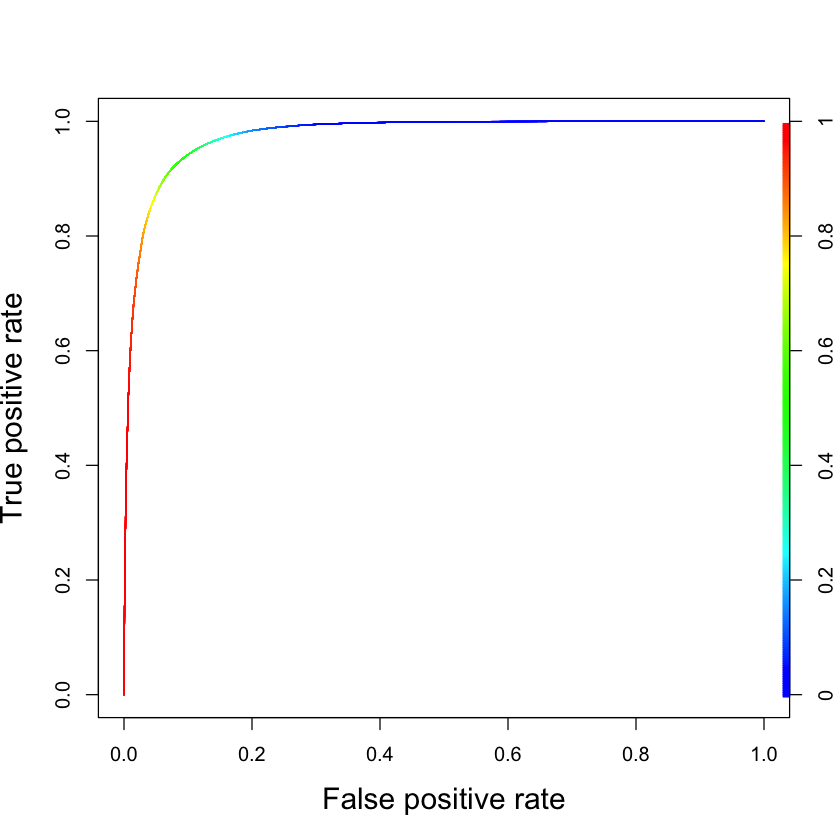

In [111]:
# ROC plot
log_ROCRpred <- prediction(log_test, test$class)
log_ROCRperf <- performance(log_ROCRpred, 'tpr', 'fpr')
plot(log_ROCRperf, colorize = TRUE, cex.lab=1.5)

In [112]:
# AUC
log_perf_AUC <- performance(log_ROCRpred,"auc")
log_AUC <- log_perf_AUC@y.values[[1]]
print(paste("AUC: ", log_AUC))

[1] "AUC:  0.976253226336373"


#### Estimate Bias and Variance
#### 1. First, use bootstrapping to create 10 smaple data sets.
#### 2. run 10 models.

In [92]:
# Bootstrapping
set.seed(43)
runModel <- function(df) { glm(class~.,data = df[sample(1:nrow(df),nrow(df),replace=T),], family=binomial(link=logit)) }
lapplyrunmodel <- function(x) runModel(train)
log_models <- lapply(1:10, lapplyrunmodel)

In [94]:
log_preds <- lapply(log_models, FUN = function(M, D=test[,-c(15)]) predict(M, D, type = "response"))
log_preds <- as.data.frame(log_preds)

In [95]:
# preds in all predictions from different models
# nums is the number of models

bias.variance <- function (preds, nums){
    mean_pred <- rowMeans(preds)
    #Bias
    bias = 0
    for (i in 1:length(test$class)){
        bias = bias + (mean_pred[i]-test$class[i])^2
    }
    bias = bias / length(test$class)
    
    #Variance
    var = 0
    for (i in 1:nums){
        for (j in 1:length(test$class)){
            var = var + (preds[,i][j]-mean_pred[i])^2
        }
        var = var / length(test$class)
    }
    var = var / nums
    
    b_v <- matrix(c(bias, var), ncol=1)
    colnames(b_v) <- c("Value")
    rownames(b_v) <- c("Bias","Variance")
    b_v <- as.data.frame(b_v)
    head(b_v)
    
}

In [96]:
log_b_v <- bias.variance(log_preds, 10)
print(log_b_v)

              Value
Bias     0.11648013
Variance 0.03162668


### Algorithm 2: Naive Bayes

In [3]:
start_time <- Sys.time()
nb_model <- naiveBayes(class~., data=train)
end_time <- Sys.time()
nb_train_difference <- difftime(end_time, start_time, units='secs')
print(nb_train_difference)

Time difference of 1.284837 secs


In [4]:
summary(nb_model)

          Length Class  Mode     
apriori    2     table  numeric  
tables    18     -none- list     
levels     2     -none- character
isnumeric 18     -none- logical  
call       4     -none- call     

In [115]:
# naive bayes model accuracy on training data.
nb_train <- predict(nb_model, train[, c(-15)], type="class")
nb_train_table_mat = table(train$class, nb_train) 
nb_train_accuracy <- sum(diag(nb_train_table_mat)) / sum(nb_train_table_mat)
print(paste("train accuracy: ", nb_train_accuracy))

[1] "train accuracy:  0.892799314051666"


In [159]:
# performance on test data set.
start_time <- Sys.time()
nb_test_raw <- predict(nb_model, test[, c(-15)], type="raw")
nb_test_class <-unlist(apply(round(nb_test_raw),1,which.max))-1
end_time <- Sys.time()
nb_pred_difference <- end_time - start_time
print(nb_pred_difference)

Time difference of 1.403602 mins


In [117]:
nb_test_table_mat <- table(test$class, nb_test_class)
print(nb_test_table_mat)

   nb_test_class
         0      1
  0  60732  10031
  1   8996 120241


In [118]:
nb_performance <- test.performance(nb_test_table_mat)
print(nb_performance)

[1] "Performance on test data"
                        Value
Accuracy            0.9048650
Precision           0.9229996
Recall(sensitivity) 0.9303915
FPR                 0.1417549
TNR(specificity)    0.8582451
F1                  0.9266808


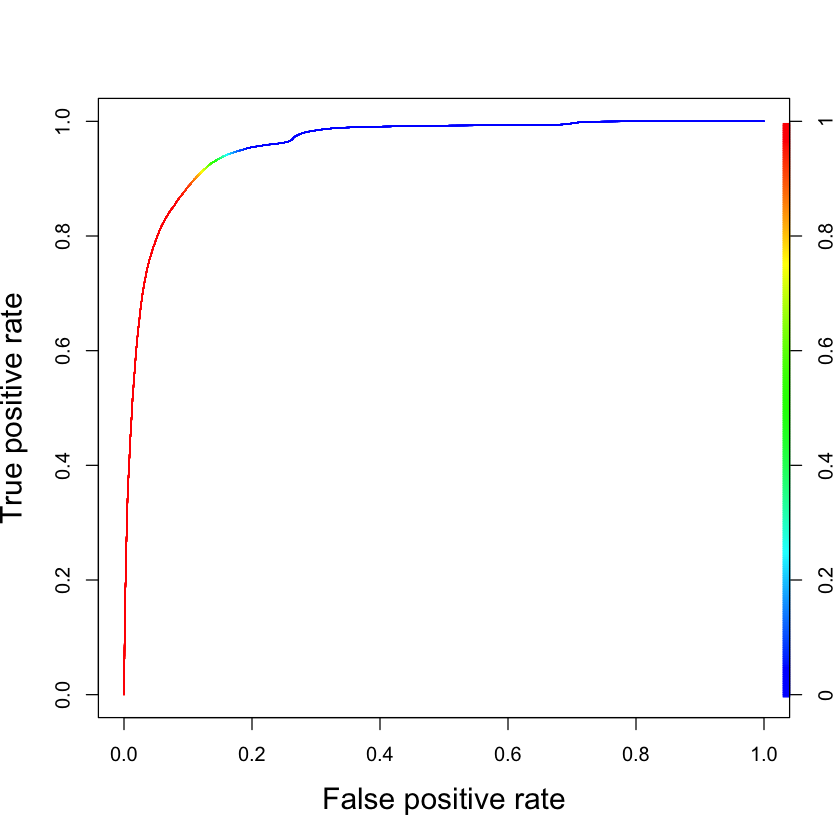

In [125]:
# ROC plot
nb_ROCRpred <- prediction(nb_test_raw[, "1"], test$class) #nb_test_raw has two columns: "0": P(x=0), "1": P(x=1)
nb_ROCRperf <- performance(nb_ROCRpred, 'tpr', 'fpr')
plot(nb_ROCRperf, colorize = TRUE, cex.lab=1.5)

In [126]:
# AUC
nb_perf_AUC <- performance(nb_ROCRpred,"auc")
nb_AUC <- nb_perf_AUC@y.values[[1]]
print(paste("AUC: ", nb_AUC))

[1] "AUC:  0.958689424878438"


In [127]:
# Bootstrapping
set.seed(43)
runModel <- function(df) { naiveBayes(class~., data = df[sample(1:nrow(df),nrow(df),replace=T),]) }
lapplyrunmodel <- function(x) runModel(train)
nb_models <- lapply(1:10, lapplyrunmodel)

In [128]:
start_time <- Sys.time()
cl <- makeCluster(3)
clusterExport(cl, c("naiveBayes", "test"), envir=environment())
nb_preds <- parLapply(cl, nb_models, function(M, D=test[,-c(15)]) predict(M, D, type="raw"))
stopCluster(cl)
end_time <- Sys.time()

In [129]:
difference <- difftime(end_time, start_time, units='mins')
print(difference)

Time difference of 3.05953 mins


In [133]:
nb_preds <- as.data.frame(nb_preds)[,c(2,4,6,8,10,12,14,16,18,20)]
nb_b_v <- bias.variance(nb_preds, 10)
print(nb_b_v)

ERROR: Error in `[.data.frame`(as.data.frame(nb_preds), , c(2, 4, 6, 8, 10, 12, : undefined columns selected


### Algorithm 3: SVM

In [157]:
#split training data set into 11 disjoint sub data sets. Each sub training data sets will have 51316 observations.
sub_trains <- list()
set.seed(43)
train_index <- 1: nrow(train)
each_train <-  round(nrow(train)/11)

for (i in 1:10){
    sub <- sample(train_index, each_train, replace=F)
    sub_trains[[length(sub_trains)+1]] <- sub
    train_index <- setdiff(train_index, sub)
}

#the left observations is the 11 sub training data set.
sub_trains[[length(sub_trains)+1]] <- train_index

In [ ]:
start_time <- Sys.time()
cl <- makeCluster(6)
clusterExport(cl, c("svm", "train", "sub_trains"), envir=environment())
svm_models <- parLapply(cl, 1:11,  function(i) svm(class~., data = train[sub_trains[[i]],], probability=TRUE) )
end_time <- Sys.time()
svm_train_difference <- difftime(end_time, start_time, units='hours')
print(svm_train_difference)
#Time difference: 19 mins

In [ ]:
# prediction: majority votes
#performance on training data set.

svm_trains <- lapply(1:11,  function(i) predict(svm_models[[i]], train[sub_trains[[i]], c(-15)], probability=TRUE) )
svm_train_probs <- lapply(1:11, function(i) attr(svm_trains[[i]], "probabilities")[,"1"])
svm_train_table_mats <- lapply(1:11, function(i) table(train[sub_trains[[i]],]$class, svm_train_probs[[i]] > 0.5) )
svm_train_accuracies <- lapply(1:11, function(i) sum(diag(svm_train_table_mats[[i]])) / sum(svm_train_table_mats[[i]]) )
svm_print_accuracies <- lapply(1:11, function(i) print(paste("train accuracy for model ", i, ": ", svm_train_accuracies[[i]])) )

In [ ]:
# test performance: majority votes.
# use mean probabilities to represent the final 
start_time <- Sys.time()
svm_tests <- lapply(1:11,  function(i) predict(svm_models[[i]], test[, c(-15)], probability=TRUE) )
svm_test_probs <- lapply(1:11, function(i) attr(svm_tests[[i]], "probabilities")[,"1"])
svm_test_classes <- lapply(1:11, function(i) ifelse(svm_test_probs[[i]]>0.5, 1, 0))

getmode <- function(v) {
    uniqv <- unique(v)
    uniqv[which.max(tabulate(match(v, uniqv)))]
}                          
                           
svm_test_class <- vector()
svm_test_prob <- vector()
for (i in 1: length(test$class)){
    temp_class <- vector()
    temp_prob <- vector()
    for (j in 1: 11){
        temp_class <- append(temp_class, svm_test_classes[[j]][[i]])      
        temp_prob <- append(temp_prob, svm_test_probs[[j]][[i]])
    }
    svm_test_class <- append(svm_test_class, getmode(temp_class))
    svm_test_prob <- append(svm_test_prob, mean(temp_prob))
}    

end_time <- Sys.time()
svm_pred_difference <- end_time - start_time
print(svm_pred_difference)

In [ ]:
svm_test_table_mat <- table(test$class, svm_test_class)
print(svm_test_table_mat)

In [ ]:
svm_performance <- test.performance(svm_test_table_mat)
print(svm_performance)

In [ ]:
# ROC plot
svm_ROCRpred <- prediction(svm_test_prob, test$class)
svm_ROCRperf <- performance(svm_ROCRpred, 'tpr', 'fpr')
plot(svm_ROCRperf, colorize = TRUE, cex.lab=1.5)

In [ ]:
# AUC
svm_perf_AUC <- performance(svm_ROCRpred,"auc")
svm_AUC <- svm_perf_AUC@y.values[[1]]
print(paste("AUC: ", svm_AUC))
#[1] "AUC:  0.989536392785673"

In [ ]:
svm_preds <- as.data.frame(svm_test_probs)
svm_b_v <- bias.variance(svm_preds, 11)
print(svm_b_v)
#[1] "bias:  0.0361489712064151"
#[1] "variance:  0.0307869096625712"

### Algorithm 4: Decision Tree

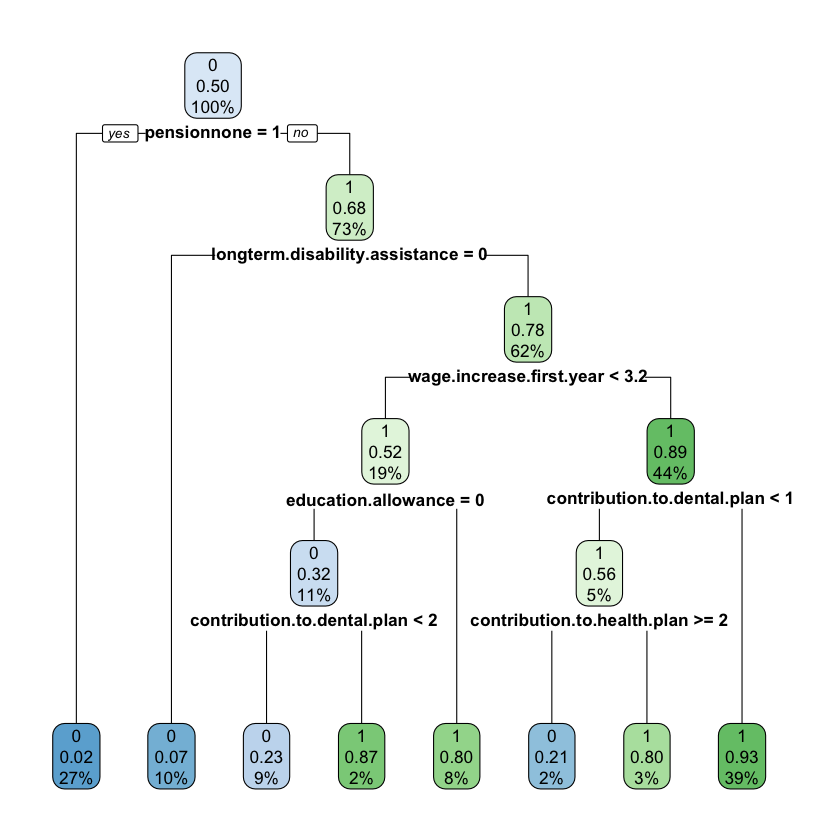

In [135]:
start_time <- Sys.time()
set.seed(43)
dt_model <- rpart(class~., data=train, method="class")
end_time <- Sys.time()
rpart.plot(dt_model, extra = 106, fallen.leaves = T)

In [136]:
dt_train_difference <- difftime(end_time, start_time, units='secs')
print(dt_train_difference)

Time difference of 30.25825 secs


In [139]:
dt_model

n= 564474 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 564474 282237 0 (0.50000000 0.50000000)  
   2) pensionnone>=0.5 154943   3830 0 (0.97528123 0.02471877) *
   3) pensionnone< 0.5 409531 131124 1 (0.32018089 0.67981911)  
     6) longterm.disability.assistance< 0.5 57089   3786 0 (0.93368250 0.06631750) *
     7) longterm.disability.assistance>=0.5 352442  77821 1 (0.22080513 0.77919487)  
      14) wage.increase.first.year< 3.237653 104705  50265 1 (0.48006303 0.51993697)  
        28) education.allowance< 0.5 61476  19903 0 (0.67624764 0.32375236)  
          56) contribution.to.dental.plan< 1.5 52505  12055 0 (0.77040282 0.22959718) *
          57) contribution.to.dental.plan>=1.5 8971   1123 1 (0.12518114 0.87481886) *
        29) education.allowance>=0.5 43229   8692 1 (0.20106873 0.79893127) *
      15) wage.increase.first.year>=3.237653 247737  27556 1 (0.11123086 0.88876914)  
        30) contribution.to.dental.plan< 0.5 25813  11303 1 (0.

In [142]:
# decision tree model accuracy on training data.
dt_train <- predict(dt_model, train[, c(-15)], type="class")
dt_train_table_mat = table(train$class, dt_train) 
dt_train_accuracy <- sum(diag(dt_train_table_mat)) / sum(dt_train_table_mat)
print(paste("train accuracy: ", dt_train_accuracy))

[1] "train accuracy:  0.909627369905434"


In [ ]:
# performance on test data set.
start_time <- Sys.time()
dt_test_raw <- predict(dt_model, test[, c(-15)], type="prob")
dt_test_class <-unlist(apply(round(dt_test_raw),1,which.max))-1
end_time <- Sys.time()
dt_pred_difference <- difftime(end_time, start_time, units='secs')
print(dt_pred_difference)

In [143]:
dt_test_table_mat <- table(test$class, dt_test_class)
print(dt_test_table_mat)

   dt_test_class
         0      1
  0  63407   7356
  1   9620 119617


In [147]:
dt_performance <- test.performance(dt_test_table_mat)
print(dt_performance)

[1] "Performance on test data"
                        Value
Accuracy            0.9151200
Precision           0.9420664
Recall(sensitivity) 0.9255631
FPR                 0.1039526
TNR(specificity)    0.8960474
F1                  0.9337419


In [119]:
# Since the result from decision tree is not a rank (score), we need to create the score for ROC plot.
# We create the score by using the frequence of positive samples in leaves
# dt_test <- test
# dt_test$score <- NA

# attach(dt_test)
# dt_test$score[pensionnone == 1] = 0.02
# dt_test$score[pensionnone != 1 & longterm.disability.assistance == 0] = 0.07
# dt_test$score[pensionnone != 1 & longterm.disability.assistance != 0 & wage.increase.first.year < 3.2 & education.allowance == 0 & contribution.to.dental.plan < 2] = 0.23
# dt_test$score[pensionnone != 1 & longterm.disability.assistance != 0 & wage.increase.first.year < 3.2 & education.allowance == 0 & contribution.to.dental.plan >= 2] = 0.88
# dt_test$score[pensionnone != 1 & longterm.disability.assistance != 0 & wage.increase.first.year < 3.2 & education.allowance != 0] = 0.80
# dt_test$score[pensionnone != 1 & longterm.disability.assistance != 0 & wage.increase.first.year >= 3.2 & contribution.to.dental.plan < 1 & contribution.to.health.plan >= 2] = 0.21
# dt_test$score[pensionnone != 1 & longterm.disability.assistance != 0 & wage.increase.first.year >= 3.2 & contribution.to.dental.plan < 1 & contribution.to.health.plan < 2] = 0.80
# dt_test$score[pensionnone != 1 & longterm.disability.assistance != 0 & wage.increase.first.year >= 3.2 & contribution.to.dental.plan >= 1] = 0.93
# detach(dt_test)


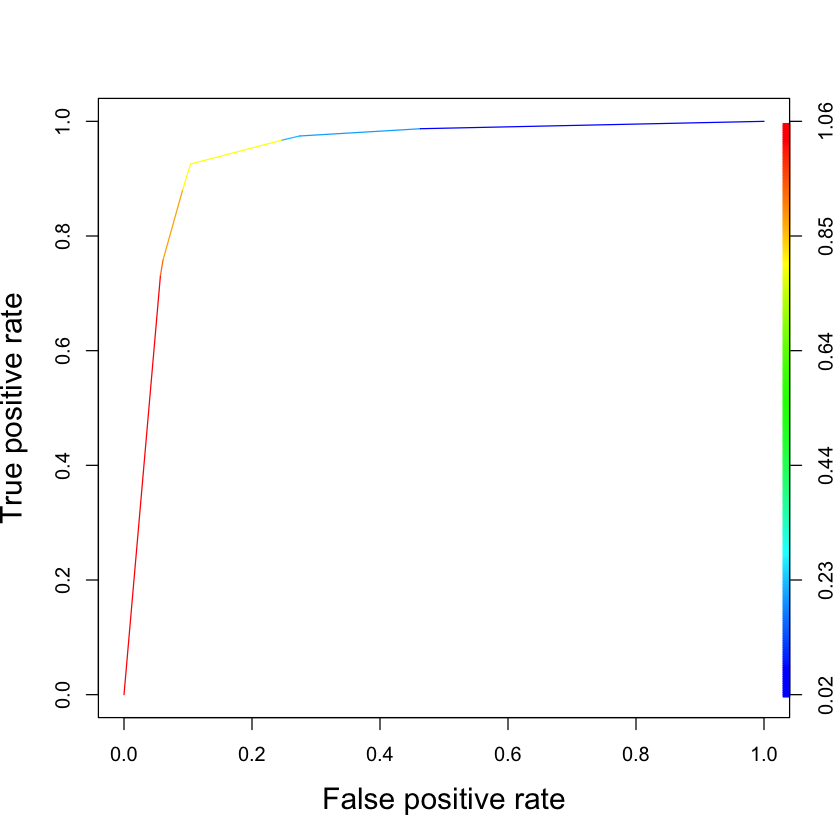

In [145]:
# ROC plot
dt_ROCRpred <- prediction(dt_test_raw[,"1"], test$class)
dt_ROCRperf <- performance(dt_ROCRpred, 'tpr', 'fpr')
plot(dt_ROCRperf, colorize = TRUE, cex.lab=1.5)

In [146]:
# AUC
dt_perf_AUC <- performance(dt_ROCRpred,"auc")
dt_AUC <- dt_perf_AUC@y.values[[1]]
print(paste("AUC: ", dt_AUC))

[1] "AUC:  0.940553071125794"


In [122]:
# Bootstrapping
start_time <- Sys.time()
set.seed(43)
cl <- makeCluster(3)
runModel <- function(df) { rpart(class~.,data = df[sample(1:nrow(df),nrow(df),replace=T),], method="class") }
lapplyrunmodel <- function(x) runModel(train)

clusterExport(cl, c("runModel", "rpart", "train"), envir=environment())
dt_models <- parLapply(cl, 1:10, lapplyrunmodel)
stopCluster(cl)

end_time <- Sys.time()
difference <- difftime(end_time, start_time, units='mins')
print(difference)

Time difference of 2.616454 mins


In [134]:
cl <- makeCluster(3)
clusterExport(cl, c("rpart", "test"), envir=environment())
dt_preds <- parLapply(cl, dt_models, function(M, D=test[,-c(15)]) predict(M, D, type="prob"))
stopCluster(cl)

Time difference of 0.2504144 mins


In [143]:
dt_preds <- as.data.frame(dt_preds)[,c(2,4,6,8,10,12,14,16,18,20)]
dt_b_v <- bias.variance(dt_preds, 10)
print(dt_b_v)

[1] "bias:  0.0726585446267699"
[1] "variance:  0.0263920540572272"


### Algorithm 5: KNN

In [171]:
start_time <- Sys.time()
set.seed(43)
knn_test <- knn(train = train[, c(-15)], test = test[, c(-15)], cl = train$class, k=10, prob=TRUE)
end_time <- Sys.time()

# pros: KNN does not need to train. cons: Prediction is time consuming.
knn_pred_difference <- difftime(end_time, start_time, units='mins')
print(knn_pred_difference)

Time difference of 22.30833 mins


In [172]:
knn_test_table_mat = table(test$class, knn_test)
print(knn_test_table_mat)

   knn_test
         0      1
  0  64593   6170
  1   4482 124755

In [175]:
knn_performance <- test.performance(knn_test_table_mat)
print(knn_performance)

[1] "Performance on test data"


,Value
,<dbl>
Accuracy,0.94674000
Precision,0.95287378
Recall(sensitivity),0.96531953
FPR,0.08719246
TNR(specificity),0.91280754
F1,0.95905628


In [181]:
#change knn probability to the probability of sample is class 1
#knn() function in class only returns the highest probability. The original knn probability is the probability of the class knn predict.
#if the predicted class is 0, the probability will be p[x=0], which needs to be changed to p[x=1] = 1-p[x=0].

knn_new_prob <- attr(knn_test,"prob")
for (i in 1:length(knn_new_prob)) {
    if (knn_test[i] == 0) knn_new_prob[i] = 1-knn_new_prob[i]  
}

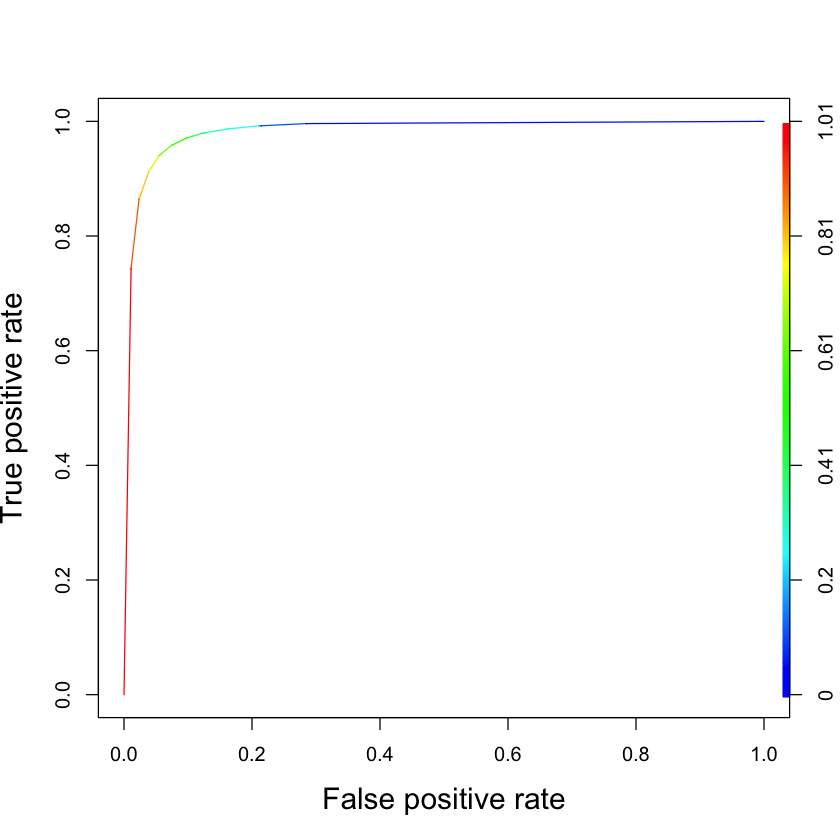

In [182]:
# ROC plot
knn_ROCRpred <- prediction(knn_new_prob, test$class)
knn_ROCRperf <- performance(knn_ROCRpred, 'tpr', 'fpr')
plot(knn_ROCRperf, colorize = TRUE, cex.lab=1.5)

In [183]:
# AUC
knn_perf_AUC <- performance(knn_ROCRpred,"auc")
knn_AUC <- knn_perf_AUC@y.values[[1]]
print(paste("AUC: ", knn_AUC))

[1] "AUC:  0.982253854700675"


In [186]:
# Bootstrapping
start_time <- Sys.time()
pcl <- makeCluster(10)
set.seed(43)
lapplyrunmodel <- function(x) { 
    sub_train <- train[sample(1:nrow(train),nrow(train),replace=T), ]
    knn(train = sub_train[, c(-15)], test = test[, c(-15)], cl = sub_train$class, k=10, prob=TRUE) 
}
clusterExport(pcl, c("lapplyrunmodel", "knn", "train", "test"), envir=environment())
knn_models <- parLapply(pcl, 1:10, lapplyrunmodel)
stopCluster(pcl)

end_time <- Sys.time()
difference <- difftime(end_time, start_time, units='hours')
print(difference)
# Time difference of 0.8315365 hours

In [ ]:
knn_preds <- list()
for (i in 1:10){
    temp_pred <- attr(knn_models[[i]], "prob")
    for (j in 1:length(temp_pred)) {
    if (knn_models[[i]][j] == 0) temp_pred[j] = 1-temp_pred[j]  
    }
    knn_preds[[length(knn_preds)+1]] <- temp_pred
}
knn_preds <- as.data.frame(knn_preds)

In [ ]:
knn_b_v <- bias.variance(knn_preds, 10)
print(knn_b_v)

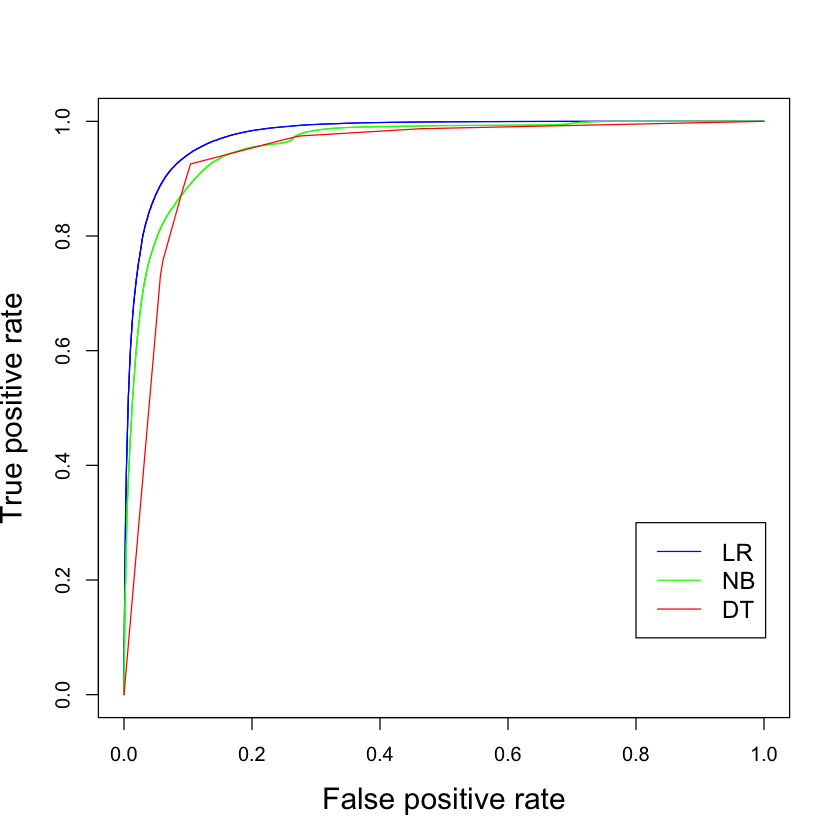

In [205]:
rocs <- plot(log_ROCRperf, cex.lab=1.5, col = "blue")
rocs <- plot(nb_ROCRperf, col ="green", add = TRUE)
rocs <- plot(svm_ROCRperf, col ="black", add = TRUE)
rocs <- plot(dt_ROCRperf, col ="red", add = TRUE)
rocs <- plot(knn_ROCRperf, col ="yellow", add = TRUE)
legend(0.8, 0.3, legend=c("LR", "NB", "SVM", "DT", "KNN"), col=c("blue", "green", "black", "red", "yellow"), lty=1, cex=1.2)

In [156]:
times <- matrix(c(paste(round(log_train_difference[[1]]), units(log_train_difference)), 
                          paste(round(log_pred_difference[[1]]), units(log_pred_difference)),
                          paste(round(nb_train_difference[[1]]), units(nb_train_difference)), 
                          paste(round(nb_pred_difference[[1]]), units(nb_pred_difference)),
                          paste(round(svm_train_difference[[1]]), units(svm_train_difference)),
                          paste(round(svm_pred_difference[[1]]), units(svm_pred_difference)),
                          paste(round(dt_train_difference[[1]]), units(dt_train_difference)),
                          paste(round(dt_pred_difference[[1]]), units(dt_pred_difference)),
                          '/', paste(round(knn_pred_difference[[1]]), units(knn_pred_difference))), nrow=2)
colnames(times) <- c("LR", "NB", "SVM", "DT", "KNN")
rownames(times) <- c("training time", "testing time")
print(times)

,Logistic Regression,Naive Bayes,SVM,Decision Tree,KNN
,<chr>,<chr>,<chr>,<chr>,<chr>
time,6 secs,1 secs,19 mins,30 secs,22 mins


In [167]:
performances <- cbind(log_performance, nb_performance, svm_performance, dt_performance, knn_performance)
performances <- rbind(performances, c(log_AUC, nb_AUC, svm_AUC, dt_AUC, knn_AUC))
colnames(performances) <- c("LR", "NB", "SVM", "DT", "KNN")
rownames(performances)[7] <- c("AUC")
print(performances)

,Value,Value
,<dbl>,<dbl>
Accuracy,0.9254050,0.9048650
Precision,0.9491725,0.9229996
Recall(sensitivity),0.9346085,0.9303915
FPR,0.0914037,0.1417549
TNR(specificity),0.9085963,0.8582451
F1,0.9418342,0.9266808


In [ ]:
bvs <- cbind(log_b_v, nb_b_v, svm_b_v, dt_b_v, knn_b_v)
colnames(bvs) <- c("LR", "NB", "SVM", "DT", "KNN")
total_error <- bvs["Bias", ] + bvs["Variance", ]
bvs <- rbind(bvs, total_error)
rownames(bvs)[3] <- c("Total Error")
print(bvs)

In [186]:
log_class <- ifelse(log_test > 0.5,1,0) 
log_class <- as.data.frame(log_class)
nb_class <- as.data.frame(nb_test_class)
colnames(nb_class) <- c("nb_class")
svm_class <- as.data.frame(svm_test_class)
colnames(svm_class) <- c("svm_class")
dt_class <- as.data.frame(dt_test_class)
colnames(dt_class) <- c("dt_class")
knn_class <- as.data.frame(knn_test)
colnames(knn_class) <- c("knn_class")
result <- cbind(test, log_class, nb_class, svm_class, dt_class, knn_class)
result <- result %>% relocate(class, .after = pensionret_allw)
head(result)

,duration,wage.increase.first.year,wage.increase.second.year,wage.increase.third.year,working.hours,standby.pay,shift.differential,education.allowance,statutory.holidays,vacation,⋯,contribution.to.dental.plan,bereavement.assistance,contribution.to.health.plan,class,cost.of.living.adjustmenttc,cost.of.living.adjustmenttcf,pensionnone,pensionret_allw,log_class,nb_test_class
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2,2.675478,4.562002,2.384273,38.21172,2.000000,1.924700,0,9.514273,1,⋯,2,1,2,0,0,0,1,0,0,0
16,1,6.767568,3.102079,5.000000,38.26002,2.000000,1.995510,0,11.000000,3,⋯,2,1,2,1,0,0,0,0,1,1
25,3,3.791899,6.446193,5.000000,40.00000,9.223949,4.222744,0,11.000000,1,⋯,2,1,2,1,1,0,0,0,1,1
29,3,4.552662,5.399940,5.000000,40.00000,2.000000,3.000000,0,10.015408,1,⋯,1,1,1,1,0,0,0,0,1,1
30,3,2.018320,2.335967,5.000000,40.00000,2.000000,5.000000,1,12.000000,1,⋯,0,1,1,0,1,0,0,0,0,0
31,2,4.477106,3.097143,5.000000,40.00000,2.000000,5.000000,0,11.000000,1,⋯,2,1,2,1,0,1,0,0,1,1


In [ ]:
dev.off()